# Mathematical Modeling and Numerical Simulation of Absorption and Desorption of Hydrogen in Long Metal Hydride Tank Equipped with Phase Change Material Jacket 

## Darzi e.a. - Journal Hydrogen Energy 2016 

## Import Julia Packages 

In [1]:
using LinearAlgebra
using DifferentialEquations
using Plots

In [88]:
# deliberately use include to include code 
# see e.g. https://docs.julialang.org/en/v1/manual/code-loading/ 
include("flemish-fish.jl")

In [3]:
?fdmmesh

search: fdmmesh



Generates a one-dimensional uniform mesh between point 0 and 1

Input N(1) is number of elements. Output is the one-dimensional mesh. 

[`mesh(::NTuple{1,Int})`](@ref)

---

Generates a one-dimensional uniform mesh between point a and b

Input N(1) is number of elements. Output is the one-dimensional mesh. 

[`mesh(::NTuple{1,Int},::Real,::Real)`](@ref)

---

Generates a two-dimensional mesh between the points (0,0) and (1,1) 

Input N(1) and N(2) are the number of elements in x and y direction. Output is the two-dimensional mesh. 

[`mesh(::NTuple{2,Int})`](@ref)

---

Generates a two-dimensional mesh between the points a and b 

Input N(1) and N(2) are the number of elements in x and y direction. Output is the two-dimensional mesh. 

[`mesh(::NTuple{2,Int},::Point2D,::Point2D)`](@ref)


## Section 1: Introduction 
The <b>goals</b> of this notebook are:  
1. to reproduce the results by Darzi e.a. in their 2016 paper entitled <i>Absorption and Desorption of Hydrogen in Long Metal Hydride Tank Equipped with Phase Change Material Jacket</i>. This paper discusses the mathematical modeling and numerical simulation of metal-hydride materials for the storage (absorption (intake) and desorption (release)) of hygrogen gas. The [Van 't Hoff plot](https://en.wikipedia.org/wiki/Van_'t_Hoff_equation) is used to estimate the enthalpy (heat intake or release) and entropy of the chemical reaction of binding and release of hydrogen gas; 
2. collect information allowing an informed and critical discussion on future outlook with project partners;   

<img src="./darzi-2016-table1.png" width=800 />
Table-1 from Darzi-2016. 

More on the introduction will come later. 

<b>Next steps</b>
1. specify equations in the remainder of the notebook;
2. prepare rectangular 2D mesh geometry using GMSH (assuming here that the package VoronoiFVM is able to read it); 

## Section 2: Solid Density in Spatially Homogenous Reactor 
<b>Assumptions</b>: 
1. the reactor to be spatially homogeneous (well stirred reactor model, reactor has no spatial dimensions); 
1. pressure and temperature of reactor are constant; 
1. given empty bed density $\rho_{emp}$: see Table-1 for realistic value;  
1. saturated bed density $\rho_{sat}$: see Table-1 for realistic value?; 

<b>Problem Formulation</b>:

Model time-evolution of density of hydrogen gas bounded to the metal-oxide solid $\rho_s = \rho_s(t)$ in both absorption and desorption conditions, i.e, solve the (single) ordinary differential equation  

$$
(1 - \epsilon) \frac{d \, \rho_s}{dt} = \dot{m}(\rho_s, t) 
\text{ given } \rho_s(t = 0) = \rho_{s,0} \,    
$$

where for <b>absorption</b> conditions (density of solid increases until reaching saturation)

$$
\dot{m}(\rho_s, t) = \dot{m}_a(\rho_s, t)
                   = C_a \exp(- \frac{E_a}{R \, T}) \, 
                        \log( \frac{p_p}{p_{eq,a}} ) \, (\rho_{sat} - \rho_s(t)) \, ,     
$$

and for <b>desorption</b> conditions (density decreases until reaching minimum value)

$$
\dot{m}(\rho_s, t) = \dot{m}_d(\rho_s, t)
                   = C_d \exp(- \frac{E_d}{R \, T}) \, 
                         ( \frac{p_p - p_{eq,d}}{p_{eq,d}} ) \, 
                         (\rho_s(t) - \rho_{emp}) \, ,       
$$

assuming final time to evolve between one and a few minutes. Observe that 
1. the mass flow rate $\dot{m}(\rho_s, t)$ is <i>independent</i> of the density of the gas $\rho_s(t)$;
1. the steady-state solution for absoroption and desorption is given by $\rho_s=\rho_{sat}$ and $\rho_s=\rho_{emp}$, respectively; 

<b>Coding</b>:

Code the problem set-up and solve using a suitable time-integration choosen from [DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/). Plot time evolution of $\rho_s(t)$ and $\dot{m}$. Explore the sensitivity of the computed solution w.r.t. temperature and pressure operating conditions.   

<b>Absorption Case</b> 
Here we model an absorption case. This case is seperable and can thus be solved analytically using seperation of variables, either using pen-and-paper and symbolic computations (using sympy e.g.). 

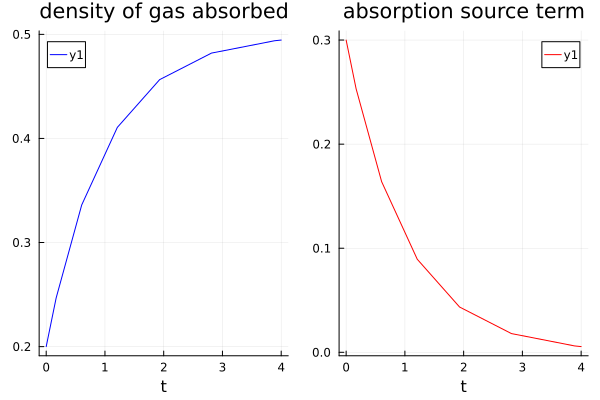

In [4]:
# problem set-up: rhs function that defines the ODE
function rhs(u,p,t)
    return (.5-u) # absorption assuming \rho_{sat} = 1 and multiplying factors equal 1
end 

# problem set-up: initial condition
u0 = .2;

# problem set-up: set time span
Tend = 4
tspan = (0.0,Tend)

# problem set-up: define ODE problem 
prob = ODEProblem(rhs,u0,tspan)

# solve: perform time integration 
sol = solve(prob,AutoVern7(Rodas5()),reltol=1e-4,abstol=1e-4)

# post-process: plot computed solution 
p1 = plot(sol.t, sol.u, xlabel = "t",line = :blue, title="density of gas absorbed")

# post-process:evaluate and plot the source term 
p2 = plot(sol.t, rhs.(sol.u,1,sol.t),xlabel="t", line = :red, title="absorption source term")
plot(p1,p2,layout=(1,2))

<b>Desorption Case</b> 
Here we model an desorption case.

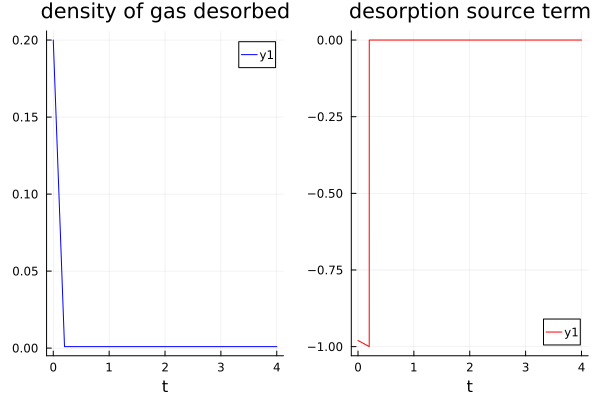

In [5]:
# problem set-up: rhs function that defines the ODE 
function rhs(u,p,t)
    return (0.1*u-1)*(u>0.001) # desorption assuming \rho_{emp} = 0.1 and rest equals 1 
end 

# problem set-up: initial condition 
u0 = .2;

# problem set-up: set time span
Tend = 4
tspan = (0.0,Tend)

# problem set-up: define ODE problem 
prob = ODEProblem(rhs,u0,tspan)

# solve: perform time integration 
sol = solve(prob,AutoVern7(Rodas5()),reltol=1e-4,abstol=1e-4)

# post-process: plot computed solution 
p1 = plot(sol.t, sol.u, xlabel = "t",line = :blue, title="density of gas desorbed")

# post-process:evaluate and plot the source term 
p2 = plot(sol.t, rhs.(sol.u,1,sol.t),xlabel="t", line = :red, title="desorption source term")
plot(p1,p2,layout=(1,2))

## Section 3: Solid/Gas Density in Spatially Homogenous Reactor

<b>Assumptions</b>: as before 

<b>Problem Formulation</b>:

Model time-evolution of hydrogen gas bounded to the metal-oxide solid $\rho_s = \rho_s(t)$ and density of the hydrogen gas $\rho_g = \rho_g(t)$  in both absorption and desorption conditions, i.e, solve the two ordinary differential equations coupled via the depency of the flow rate on the 

$$
(1 - \epsilon) \frac{d \, \rho_s}{dt} = \dot{m}(\rho_s, t) 
\text{ given } \rho_s(t = 0) = \rho_{s,0} \,    
$$

and 

$$
\epsilon \frac{d \, \rho_g}{dt} = - \dot{m}(\rho_s, t) 
\text{ given } \rho_g(t = 0) = \rho_{g,0} \, .     
$$

Not sure about signs in the equation. 

<b>Remarks</b>: what initial conditions make sense to use here? 

<b>Coding</b>: extend before from one to two coupled ordinary differential equations. 

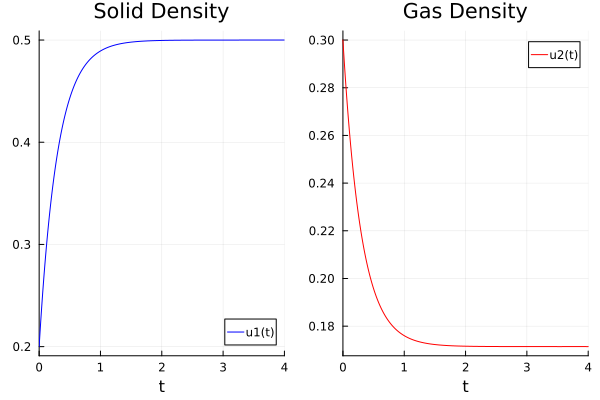

In [6]:
# problem set-up: rhs function that defines the ODE 
function rhs!(du,u,p,t)
 mdot = (.5-u[1])
 epsilon = 0.7 
 du[1] = mdot/(1-epsilon)
 du[2] = -mdot/epsilon 
end

# problem set-up: initial condition
u0 = [0.2,0.3] 

# problem set-up: set time span
Tend = 4
tspan = (0.0,Tend)

# problem set-up: define ODE problem
prob = ODEProblem(rhs!,u0,tspan)

# solve: perform time integration
sol = solve(prob)

# post-process: plot computed solution
p1 = plot(sol,idxs=1,line = :blue,title="Solid Density")
p2 = plot(sol,idxs=2,line = :red,title="Gas Density")
plot(p1,p2,layout = (1,2))

## Section 4: Solid/Gas Density with in 1D Plug Flow Reactor 

<b>Assumptions</b>:
1. assume reactor to extend in space along the $z$-axis of a cylindrical coordinate system from $z=0$ to $z = 0.8 \, \text{m}$. 
2. assume $z$-axis to be discretized using an uniform mesh; 
3. assume constant flow $u_z$ (in $\text{m}/\text{s}$) around the $z$-axis; 

<b>Problem Formulation</b>:

We assume the velocity $u_z(z)$ to be known (a-priori given). 

$$
(1 - \epsilon) \frac{\partial \, \rho_s}{\partial t} = \dot{m}(\rho_s, t) 
\text{ given } \rho_s(t = 0) = \rho_{s,0} 
\text{ and boundary conditions} \,    
$$

and 

$$
\epsilon \frac{\partial \, \rho_g}{\partial t} = 
D \, \frac{\partial^2 \, \rho_g}{\partial x^2}
+ u_z \, \frac{\partial \, \rho_g}{\partial x} 
+ \dot{m}(\rho_s, t) 
\text{ given } \rho_g(t = 0) = \rho_{g,0} 
\text{ and boundary conditions} \, .     
$$


<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space: discretize the diffusion using second-order three-point finite difference stencil (tri-diagonal matrix $S$) and first-order two-point convection (bi-diagonal matrix $C$) operator using finite differences on a uniform mesh. Alternatively, use [Ferrite](https://ferrite-fem.github.io/Ferrite.jl/stable/) in space and time. 

For <b>discretization</b> in time: using DifferentialEquations.jl as before. See e.g. [EE4375 course](https://github.com/ziolai/finite_element_electrical_engineering/tree/main) for examples. Or use e.g. [Ferrite](https://ferrite-fem.github.io/Ferrite.jl/stable/) (observe that Ferrite ha no stabilization methods for convection dominated flows, assume no stabilization require for laminar flow through porous media); 

<b>Coding of Set-up Phase</b>:

### Section 1.4: Steady State: Convection-Diffusion Equation for Gas Density $\rho_g$

Use use [Ferrite](https://ferrite-fem.github.io/Ferrite.jl/stable/) in space to verify this solution. Implement weak, intermediate and strong convection.

In [7]:
# set source function 
src(x) = 0.  

# set right-hand side 
# u''(x) = - f(x) reformulated as 
# coupled first order system as 
# u'(x) = v(x) and v'(x) = - f(x) or 
# du[1] = u[2] and du[2] = - f(x) 
function rhs!(du, u, p, x)
    rhog = u[1]; drhog = u[2]
    du[1] = drhog
    du[2] = -10*drhog + src(x)
end

# set boundary conditions 
# boundary conditions on the left and right of computational domain 
# requires explaining syntax 
function bc(residual, u, p, x)
    rhogleft = 1; rhogright=0; 
    residual[1] = u[1][1] - rhogleft 
    residual[2] = u[end][1] - rhogright
end

bc (generic function with 1 method)

In [8]:
# set constants 
p = [1]

# set domain size 
xspan = (0.,1.)

# set initial guess 
start = [0., 0.]

# define and solve the problem 
bvp = BVProblem(rhs!, bc, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.005);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


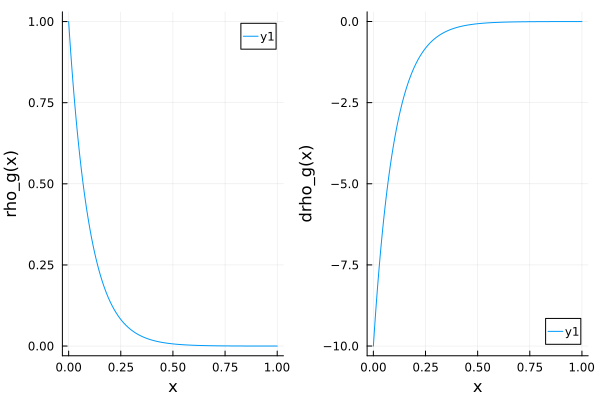

In [9]:
# plot u(x) and du/dx(x)
rhog  = [u[1] for u in sol.u]
drhog = [u[2] for u in sol.u]
p1 = plot(sol.t, rhog, xlabel="x", ylabel = "rho_g(x)") 
p2 = plot(sol.t, drhog, xlabel="x", ylabel = "drho_g(x)") 
plot(p1,p2,layout=(1,2))

### Section 2.4: Transient Model 

In [12]:
# spatial discretization 
N = (10,); Np1 = N[1]+1
m = fdmmesh(N)
A = stiffmat(m)
C = convectionmat(m);

In [86]:
# ODE model functions
function plug_flow_reactor!(du,u,p,t)
    Np1         = length(u) ÷ 2 
    rhos        = @view u[1:Np1]
    rhog        = @view u[Np1+1:end]
    mdot        = 1 .- rhos
    epsilon     = 0.5 
    du[1:Np1]  .= mdot/(1-epsilon)  
    du[Np1+1:end] .= -A*rhog - mdot/epsilon # .= A*rhog - mdot/epsilon  
    du[Np1+1] = 0; du[end] = 0 
end

# set initial conditions 
rhos0 = [.2 for xi in m[1]]
rhog0 = [.3 for xi in m[1]]; rhog0[1] = 0.; rhog0[end] = 0.;  
u0  = [rhos0; rhog0]

# set time interval 
tspan = (0.0,0.1)

# define and solve the problem 
prob = ODEProblem(plug_flow_reactor!,u0,tspan,p)
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8, save_everystep = true);

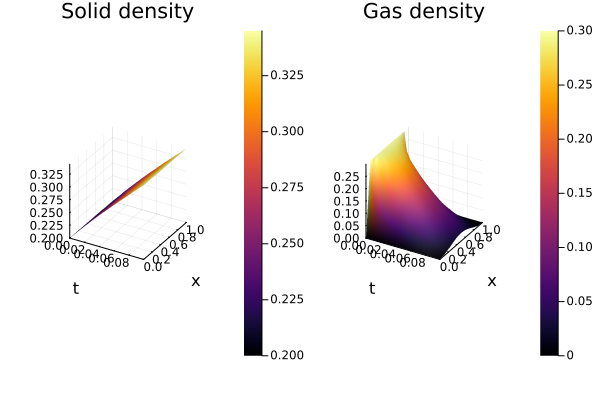

In [87]:
# post-processing 
rhosmat = reduce(hcat,[uti[1:Np1] for uti in sol.u])
rhogmat = reduce(hcat,[uti[Np1+1:end] for uti in sol.u])

p1 = surface(sol.t,m[1],rhosmat,xlabel="t", ylabel="x",title="Solid density")
p2 = surface(sol.t,m[1],rhogmat,xlabel="t", ylabel="x",title="Gas density")
plot(p1,p2,layout=(1,2))

## Section 5: Geometry Modeling and Mesh Generation 

### Geometry Modeling 

Make sure to use Physical Groups to code boundary patches for inlet, outlet, wall and symmetry. 

Represent cylinder as wedge with periodic boundary conditions. 

### Mesh Generation 

### Writing Mesh to File 

## Section 6: Solid/Gas Density in 2D Cylindrical Reactor with Porous Material  

Extend previous analysis from 1D space (only $x$) to 2D space (both $x$ and $y$). Assume a predefined velocity fiedld for the gas phase velocity. Solve 2 coupled convection-diffusion-reaction equations for $\rho_s(x,y,t)$ and $\rho_g(x,y,t)$. 
1. Adapt [Ferrite Heat Equation Tutorial](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/heat_equation/) (steady state) from from one field to be solved to two fields to be solved for;
1. Similarly, adapt [transient_heat_equation](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/transient_heat_equation/) from from one field to be solved to two fields to be solved for; 

<b>Assumptions</b>: 

<b>Problem Formulation</b>:

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time 

<b>Coding of Set-up Phase</b>:

## Section 7: Laminar Iso-Thermal Porous Media Flow (Pressure/Velocity) in Reactor 

The goal of this section is to implement a laminar flow model for the gas phase in the reactor filled with porous material.

Adapt [Ferrite Porous Media Tutorial](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/porous_media/) to cylindrical reactor geometry and flow conditions;    

<b>Assumptions</b>: 

<b>Problem Formulation</b>: PDE + boundary conditions for inlet (fix velocity), outlet (fix pressure), wall (no slip) and symmetry;  

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time 

<b>Coding of Set-up Phase</b>:

## Section 8: Laminar Non-Iso-Thermal Porous Media Flow in Reactor

Add heat effects to the flow field.  

<b>Assumptions</b>: 

<b>Problem Formulation</b>:

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time 

<b>Coding of Set-up Phase</b>:

## Section 9: Hydrogen Ab/Desoprtion in Reactor 

Ad hydrogen absorption and desorption to the model. 

<b>Assumptions</b>: 

<b>Problem Formulation</b>:

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time 

<b>Coding of Set-up Phase</b>:

## Section 10: Conclusions 